## Chapter 2 - Causal Diagram and Conditional Independence

<a target="_blank" href="https://colab.research.google.com/github/CausalAILab/causalai-book/blob/main/ch2 (part 2).ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import os
import sys

if 'google.colab' in sys.modules:
    os.system("git clone https://github.com/CausalAILab/causalai-book.git")
    os.system("mv causalai-book/* ./")
    os.system("rm -rf causalai-book")

Recall the definition of Causal Diagram from Section 2.4.1.

### Definition 2.4.1 — Causal Diagram
Consider an SCM $\mathbf{M} = \langle \mathbf{U}, \mathbf{V}, \mathcal{F}, P(\mathbf{U}) \rangle$. Then, $\mathbf{G}$ is said to be a **causal diagram** (of $\mathbf{M}$) if constructed as follows:

1. Add a vertex for every endogenous variable in the set $\mathbf{V}$.
2. Add a directed edge $(V_j \to V_i)$ for every $V_i, V_j \in \mathbf{V}$ if $V_j$ appears as an argument of $f_i \in \mathcal{F}$.
3. Add a bidirected edge $(V_j \leftrightarrow V_i)$ for every $V_i, V_j \in \mathbf{V}$ if the corresponding $U_i, U_j \subseteq \mathbf{U}$ are correlated or the corresponding functions $f_i, f_j$ share some $U \in \mathbf{U}$ as an argument.

In [2]:
from sympy import symbols
from scm import SymbolicSCM

from src.fusion import listDSeparationPaths
from src.utils import plot_causal_diagram

#### Definition 2.4.2 — Conditional independence relation

A set of variables $\mathbf{Y}$ is said to be *conditionally independent* of another set of variables $\mathbf{X}$, given a third set $\mathbf{Z}$, if knowing the values of $\mathbf{X}$ does not change the likelihood of $\mathbf{Y}$ given $\mathbf{Z}$. Formally, this statement is written as:

$$
P(\mathbf{Y} = \mathbf{y} \mid \mathbf{X} = \mathbf{x}, \mathbf{Z} = \mathbf{z}) = P(\mathbf{Y} = \mathbf{y} \mid \mathbf{Z} = \mathbf{z}),
\tag{2.53}
$$

for all $\mathbf{x}, \mathbf{y}, \mathbf{z}$. For simplicity, the equation above is also written as $\mathbf{Y} \perp\!\!\!\perp \mathbf{X} \mid \mathbf{Z}$.

#### Example 2.10 - Causal Chain

Consider the following SCM from Example 2.10

$$
M^1 = \begin{cases}
    \mathbf V &= \{X, Y, Z\}\\
    \mathbf U &= \{U_x, U_y, U_z\}\\
    F &= \begin{cases}
        X := U_x \\
        Y := X \lor \lnot U_z \\
        Z := Z \land U_y \\
    \end{cases}\\
    P(\mathbf U) &= \begin{cases}
       U_z &\sim \mathrm{Bern}(0.5) \\
       U_x &\sim \mathrm{Bern}(0.5) \\
       U_y &\sim \mathrm{Bern}(0.5) \\
    \end{cases}
\end{cases}
$$

We may implement this SCM as follows:

In [3]:
z, x, y, uz, ux, uy = symbols('z x y uz ux uy')

m1 = SymbolicSCM(
    f={
        x : ux,
        z : x & ~uz,
        y : z & uy
    },
    pu={
        uz: 0.5,
        ux: 0.5,
        uy: 0.5,
    }
)

m1

SCM([x, z, y], [uz, ux, uy])

In [4]:
m1.query({x:1, y:1}, latex=True)

<IPython.core.display.Latex object>

In [5]:
m1.query({x:1}, latex=True)

<IPython.core.display.Latex object>

In [6]:
m1.query({y:1}, latex=True)

<IPython.core.display.Latex object>

Hence, we see that $P(X = 1, Y = 1) \neq P(X = 1) P(Y = 1)$. Feel free to play around with the values of $P(U_x), P(U_y), P(U_z)$ and the variables to see what happens.

#### Example 2.11 - Common Cause

Consider the following SCM from Example 2.10

$$
M^2 = \begin{cases}
    \mathbf V &= \{X, Y, Z\}\\
    \mathbf U &= \{U_x, U_y, U_z\}\\
    F &= \begin{cases}
        Z := U_z \\
        X := Z \lor \lnot U_x \\
        Y := Z \lor U_y \\
    \end{cases}\\
    P(\mathbf U) &= \begin{cases}
       U_z &\sim \mathrm{Bern}(0.5) \\
       U_x &\sim \mathrm{Bern}(0.5) \\
       U_y &\sim \mathrm{Bern}(0.5) \\
    \end{cases}
\end{cases}
$$

We may implement this SCM as follows:

In [7]:
z, x, y, uz, ux, uy = symbols('z x y uz ux uy')

m2 = SymbolicSCM(
    f={
        z : uz,
        x : z & ~ux,
        y : z & uy
    },
    pu={
        uz: 0.5,
        ux: 0.5,
        uy: 0.5,
    }
)

m2

SCM([z, x, y], [uz, ux, uy])

In [8]:
m2.query({x:1, y:1}, given={z:1}, latex=True)

<IPython.core.display.Latex object>

In [9]:
m2.query({x:1}, given={z:1}, latex=True)

<IPython.core.display.Latex object>

In [10]:
m2.query({y:1}, given={z:1}, latex=True)

<IPython.core.display.Latex object>

Note that $P(X = 1, Y = 1 \mid Z = 1) = P(X = 1 \mid Z = 1) P(Y = 1 \mid Z = 1)$. Feel free to play around with the values of $P(U_x), P(U_y), P(U_z)$ and the the variables to see what happens.

#### Example 2.12 - Common Effect

Consider the following SCM from Example 2.10

$$
M^3 = \begin{cases}
    \mathbf V &= \{X, Y, Z\}\\
    \mathbf U &= \{U_x, U_y, U_z\}\\
    F &= \begin{cases}
        X := U_x, \\
        Y := U_y, \\
        Z := \lnot Y \land (\lnot X \lor U_z) \\
    \end{cases}\\
    P(\mathbf U) &= \begin{cases}
       U_z &\sim \mathrm{Bern}(0.5) \\
       U_x &\sim \mathrm{Bern}(0.5) \\
       U_y &\sim \mathrm{Bern}(0.5) \\
    \end{cases}
\end{cases}
$$

We may implement this SCM as follows:

In [11]:
z, x, y, uz, ux, uy = symbols('z x y uz ux uy')

m3 = SymbolicSCM(
    f={
        x : ux,
        y : uy,
        z : ~y & (~x | uz)
    },
    pu={
        uz: 0.5,
        ux: 0.5,
        uy: 0.5,
    }
)

m3

SCM([x, y, z], [uz, ux, uy])

In [12]:
m3.query({x:1, y:1}, latex=True)

<IPython.core.display.Latex object>

In [13]:
m3.query({x:1}, latex=True)

<IPython.core.display.Latex object>

In [14]:
m3.query({y:1}, latex=True)

<IPython.core.display.Latex object>

We see that $P(X = 1, Y = 1) = P(X = 1) P(Y = 1)$. Let's condition on $Z$ and see what happens. 

In [15]:
m3.query({x:1, y:1}, given={z:0}, latex=True)

<IPython.core.display.Latex object>

In [16]:
m3.query({x:1}, given={z:0}, latex=True)

<IPython.core.display.Latex object>

In [17]:
m3.query({y:1}, given={z:0}, latex=True)

<IPython.core.display.Latex object>

Note that, $P(X = 1, Y = 1 \mid Z = 0) \neq P(X = 1 \mid Z = 1) P(Y = 1 \mid Z = 0)$. Feel free to play around with the values of $P(U_x), P(U_y), P(U_z)$ and the the variables to see what happens.

#### Example 2.13 - Common Effect (Extended)

Consider the following SCM from Example 2.10

$$
M^4 = \begin{cases}
    \mathbf V &= \{X, Y, Z, W\}\\
    \mathbf U &= \{U_x, U_y, U_z, U_w\}\\
    F &= \begin{cases}
        X := U_x, \\
        Y := U_y, \\
        Z := \lnot Y \land (\lnot X \lor U_z) \\
        W := Z \oplus U_w
    \end{cases}\\
    P(\mathbf U) &= \begin{cases}
       U_z &\sim \mathrm{Bern}(0.5) \\
       U_x &\sim \mathrm{Bern}(0.5) \\
       U_y &\sim \mathrm{Bern}(0.5) \\
       U_w &\sim \mathrm{Bern}(0.1) 
    \end{cases}
\end{cases}
$$

We may implement this SCM as follows:

In [18]:
z, x, y, w, uz, ux, uy, uw = symbols('z x y w uz ux uy uw')

m4 = SymbolicSCM(
    f={
        x : ux,
        y : uy,
        z : ~y & (~x | uz),
        w : (uw & ~z) | (~uw & z)
    },
    pu={
        uz: 0.5,
        ux: 0.5,
        uy: 0.5,
        uw: 0.1
    }
)

m4

SCM([x, y, z, w], [uz, ux, uy, uw])

In [19]:
m4.query({x:1, y:1}, given={w:1}, latex=True)

<IPython.core.display.Latex object>

In [20]:
m4.query({x:1}, given={w:1}, latex=True)

<IPython.core.display.Latex object>

In [21]:
m4.query({y:1}, given={w:1}, latex=True)

<IPython.core.display.Latex object>

Note that, $P(X = 1, Y = 1 \mid Z = 0) \neq P(X = 1 \mid Z = 1) P(Y = 1 \mid Z = 0)$. Feel free to play around with the values of $P(U_x), P(U_y), P(U_z)$ and the the variables to see what happens.

#### Example 2.13 - Common Effect (Extended)

Consider the following SCM from Example 2.10

$$
M^5 = \begin{cases}
    \mathbf V &= \{X, Y, Z\}\\
    \mathbf U &= \{U_x, U_y, U_z, U_w\}\\
    F &= \begin{cases}
        X := U_x, \\
        Y := U_y, \\
        Z := \lnot (X \oplus Y)
    \end{cases}\\
    P(\mathbf U) &= \begin{cases}
       U_x &\sim \mathrm{Bern}(0.5) \\
       U_y &\sim \mathrm{Bern}(0.5) \\
    \end{cases}
\end{cases}
$$

We may implement this SCM as follows:

In [22]:
z, x, y, ux, uy = symbols('z x y ux uy')

m5 = SymbolicSCM(
    f={
        x : ux,
        y : uy,
        z : ~((x & ~y) | (~x & y))
    },
    pu={
        ux: 0.5,
        uy: 0.5
    }
)

m5

SCM([x, y, z], [ux, uy])

In [23]:
m5.query({y:1}, given={x:1, z:1}, latex=True)

<IPython.core.display.Latex object>

In [24]:
m5.query({y:1}, given={z:1}, latex=True)

<IPython.core.display.Latex object>

We see that $P(Y = 1 \mid X = 1, Z = 1) \neq P(Y = 1 \mid Z = 1)$. 

#### Definition 2.4.3 — d-separation

Consider a causal diagram $ \mathcal{G} $ and disjoint sets of endogenous variables $ \mathbf{X}, \mathbf{Y}, \mathbf{Z} $. A path $ p $ between $ X \in \mathbf{X} $ and $ Y \in \mathbf{Y} $ in $ \mathcal{G} $ is **blocked** by $ \mathbf{Z} $ if and only if:

1. $ p $ contains a chain $ A \rightarrow B \rightarrow C $ or a fork $ A \leftarrow B \rightarrow C $ such that the middle node $ B $ is in $ \mathbf{Z} $, or

2. $ p $ contains a collider $ A \rightarrow B \leftarrow C $ such that the collision node $ B $ or any of its descendants is not in $ \mathbf{Z} $.

If $ \mathbf{Z} $ blocks every path between every $ X \in \mathbf{X} $ and $ Y \in \mathbf{Y} $ in $ \mathcal{G} $, then the pair $ \mathbf{X}, \mathbf{Y} $ is said to be **d-separated** (or "closed") given $ \mathbf{Z} $. This is written as $ (\mathbf{X} \perp\!\!\!\perp \mathbf{Y} \mid \mathbf{Z})_{\mathcal{G}} $. Otherwise, $ X \in \mathbf{X} $ and $ Y \in \mathbf{Y} $ are said to be **d-connected** ("opened").


![Example Causal Diagrams](Fig-2-16.png)

In the following examples we would input the graph in the form of `<NODES>`, `<EDGES>` and `<TASKS>` and study the d-separation between two sets of nodes.

### Example 2.15 - d-separation

In [25]:
G1_task = '''
<NODES>
C
S
R
W
L

<EDGES>
C -> S
C -> R
S -> W
R -> W
W -> L

<TASK>
treatment: S
outcome: W
adjusted: 
'''

Alternatively the contents can be read from a file as well. Now, we can get the connected and d-seprated paths between `S` and `W` using `listDSeparationPaths`. It returns a dictionary with the following items:
- `G`: The graph object
- `connectedPaths`: A list of paths that are not blocked
- `separatedPaths`: A list of paths that are blocked

In [26]:
result = listDSeparationPaths(G1_task)

The graph can now be visualized using `plot_causal_diagram` which takes the graph, a list of unblocked paths, a list of blocked paths, adjusted variables and positions of the nodes. Except the graph, all other arguments are optional.

In [35]:
graph = plot_causal_diagram(result['G'], result['connectedPaths'], result['separatedPaths'])

Note: If the following command fails to run, you may need to run 'conda install -c conda-forge graphviz' inside your conda environment

In [36]:
graph

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

### Example 2.16 - d-separation (2)

For this example, we will examine the paths between $R$ and $L$ and check whether they are blocked by $W$.

In [29]:
G2_task = '''
<NODES>
C
S
R
W
L

<EDGES>
C -> S
C -> R
S -> W
R -> W
W -> L

<TASK>
treatment: R
outcome: L
adjusted: W
'''

In [30]:
result = listDSeparationPaths(G2_task)

In [31]:
graph = plot_causal_diagram(result['G'], result['connectedPaths'], result['separatedPaths'], nodes = ['W'])
graph

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

### Example 2.17 - d-separation in non-Markovian models

Here we will check the paths between $S$ and $L$ for the non-Markovian graph in Fig. 2.16.

In [32]:
G3_task = '''
<NODES>
S
R
W
L

<EDGES>
S -- R
S -> W
R -> W
W -> L

<TASK>
treatment: S
outcome: L
adjusted: 
'''

In [33]:
result = listDSeparationPaths(G3_task)

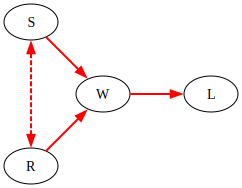

In [34]:
graph = plot_causal_diagram(result['G'], result['connectedPaths'], result['separatedPaths'], node_positions={'S': (0, 2), 'R': (0, 0), 'W': (1, 1), 'L': (2.5, 1)})
graph

### Example 2.18 - d-separation in non-Markovian Models (2)

Here we will look at the graph in Fig. 2.17 and try to find a set that blocks all paths between $X$ and $Y$.

In [35]:
G4_task = '''
<NODES>
X
T
W
Z
R
Y
S

<EDGES>
X -> W
T -> X
T -> Z
W -> Z
Z -> Y
R -> Y
Y -> S
W -- Y

<TASK>
treatment: X
outcome: Y
adjusted: 
'''

In [36]:
result = listDSeparationPaths(G4_task)

In [37]:
graph = plot_causal_diagram(result['G'], result['connectedPaths'], result['separatedPaths'])

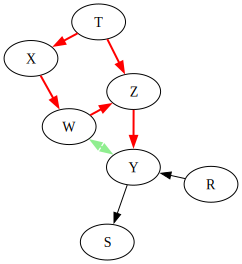

In [38]:
graph

Note, $Z = {T}$ will block paths except $X \to W \to Z \to Y$. Blocking it requires $W$ or $Z$ to be in $\mathbf{Z}$, but $X \leftarrow T \to Z \leftarrow W <-> Y$ will be unblocked in both cases. After all, there is no set $\mathbf{Z}$ that d-separates X and Y in this diagram.